In [1]:
from rdkit import Chem
import numpy as np, pandas as pd

In [2]:
from fingerprintGenerator import FragmentFingerprint

## Raw Matrix setup

In [3]:
data=pd.read_csv("data/curedData.csv")

In [4]:
SMARTS=np.loadtxt("data/smartsCSFP.csv", delimiter = "_", dtype=str, comments=None, usecols=[0])

In [5]:
CSFP=FragmentFingerprint(substructure_list=SMARTS)

In [6]:
CSFP.n_bits

1000

In [7]:
tmp = CSFP.transform_smiles(data.SMILES)
rawMatrix = pd.DataFrame.sparse.from_spmatrix(tmp)

In [8]:
rawMatrix

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
729,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
730,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
731,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Null Bits detection

In [9]:
maskNullBits = rawMatrix.apply(pd.Series.nunique, axis=0)==1

In [10]:
# 420 are composed by 0 only .. so these bits will be discarded !
rawMatrix.loc[:,maskNullBits]

,6,35,36,38,45,48,52,55,57,59,...,979,987,989,990,994,995,996,997,998,999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
729,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
rawMatrix.drop(columns=np.where(maskNullBits==True)[0], inplace=True)

## Correlation

In [12]:
corr_mat=rawMatrix.corr()
tmp_indxs=np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool_)
corr_mat=corr_mat.where(tmp_indxs)
corr_mat = corr_mat.stack().reset_index()
corr_mat.columns = ['Row','Column','Value']

In [13]:
corr_mat["Value"]=corr_mat["Value"].apply(np.absolute)
corr_thr=corr_mat[corr_mat["Value"]==1]
corr_thr.drop(columns=["Value"],inplace=True)

/tmp/ipykernel_529182/1536609274.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_thr.drop(columns=["Value"],inplace=True)


In [14]:
grouped=corr_thr.groupby("Row", as_index=False).agg(list)

toDel = set()
for _,(k,v) in grouped.iterrows():
    if k not in toDel:
        toDel |= set(v)
        
grouped=grouped[~grouped["Row"].isin(toDel)]

In [15]:
molGroups = [ [k,*v] for _,(k,v) in grouped.iterrows()]

## Manually Selection

In [17]:
import matplotlib.pyplot as plt

In [18]:
import PIL

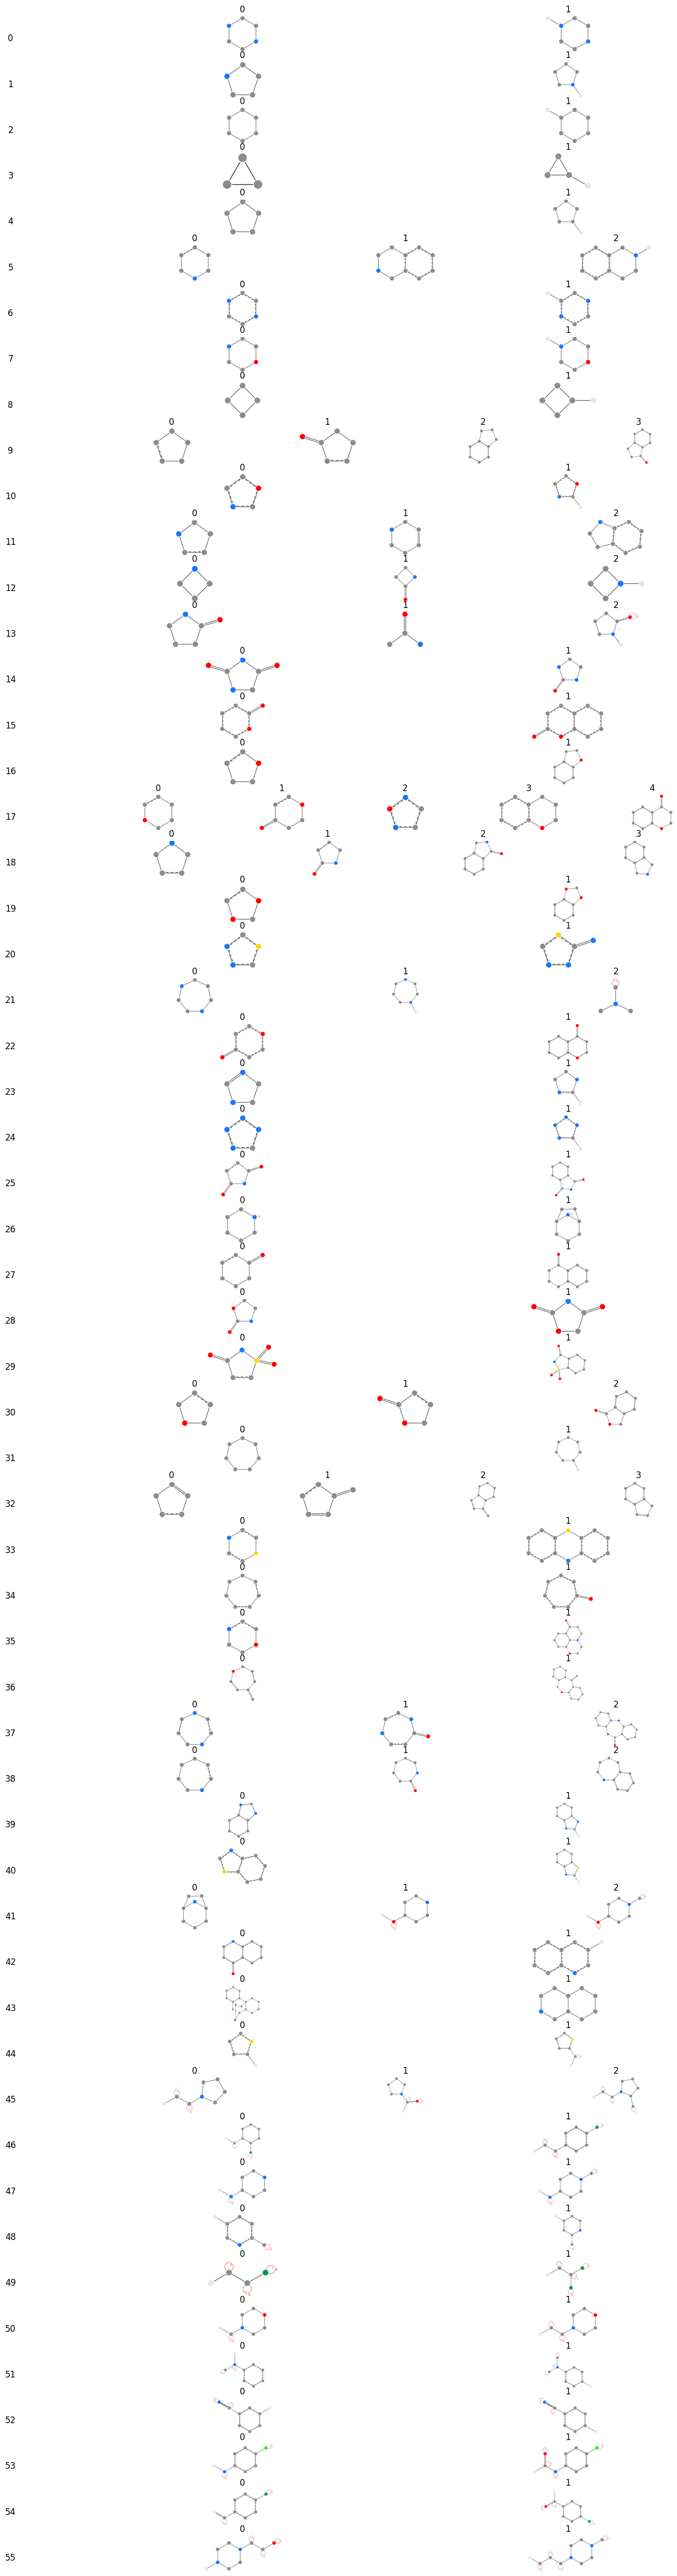

In [19]:
rows = len(molGroups)
fig = plt.figure(figsize=(15,50))
subfigs = fig.subfigures(rows,1, wspace=0.03)

for i,(subfig,molGroup) in enumerate(zip(subfigs,molGroups[:rows])):
    axes = subfig.subplots(1, len(molGroup))
    subfig.suptitle(str(i), x=0, y=.5)
    for j,(ax,molIdx) in enumerate(zip(axes,molGroup)):
        ax.imshow(PIL.Image.open(f"imgSMARTS/{molIdx}.png"),
                    aspect='equal'
                 )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("off")
        ax.set_title(str(j))

In [20]:
import itertools, json

In [21]:
# bit number 234 is too different from other fragments in own group, so it is stored
molGroups[17].pop(2)

234

In [22]:
# all bits to be stored have been manually wrote as a list json in order to select only 1 bit from each group or all
# values are referred to fragment indexes, False to store all of them
with open("data/manualSelectedCorrelation.json","r") as f:
    actions = json.load(f)

In [32]:
fig.suptitle?

Signature: fig.suptitle(t, **kwargs)
Docstring:
Add a centered suptitle to the figure.

Parameters
----------
t : str
    The suptitle text.
x : float, default: 0.5
    The x location of the text in figure coordinates.
y : float, default: 0.98
    The y location of the text in figure coordinates.
horizontalalignment, ha : {'center', 'left', 'right'}, default: center
    The horizontal alignment of the text relative to (*x*, *y*).
verticalalignment, va : {'top', 'center', 'bottom', 'baseline'}, default: top
    The vertical alignment of the text relative to (*x*, *y*).
fontsize, size : default: :rc:`figure.titlesize`
    The font size of the text. See `.Text.set_size` for possible
    values.
fontweight, weight : default: :rc:`figure.titleweight`
    The font weight of the text. See `.Text.set_weight` for possible
    values.

Returns
-------
text
    The `.Text` instance of the suptitle.

Other Parameters
----------------
fontproperties : None or dict, optional
    A dict of font prope

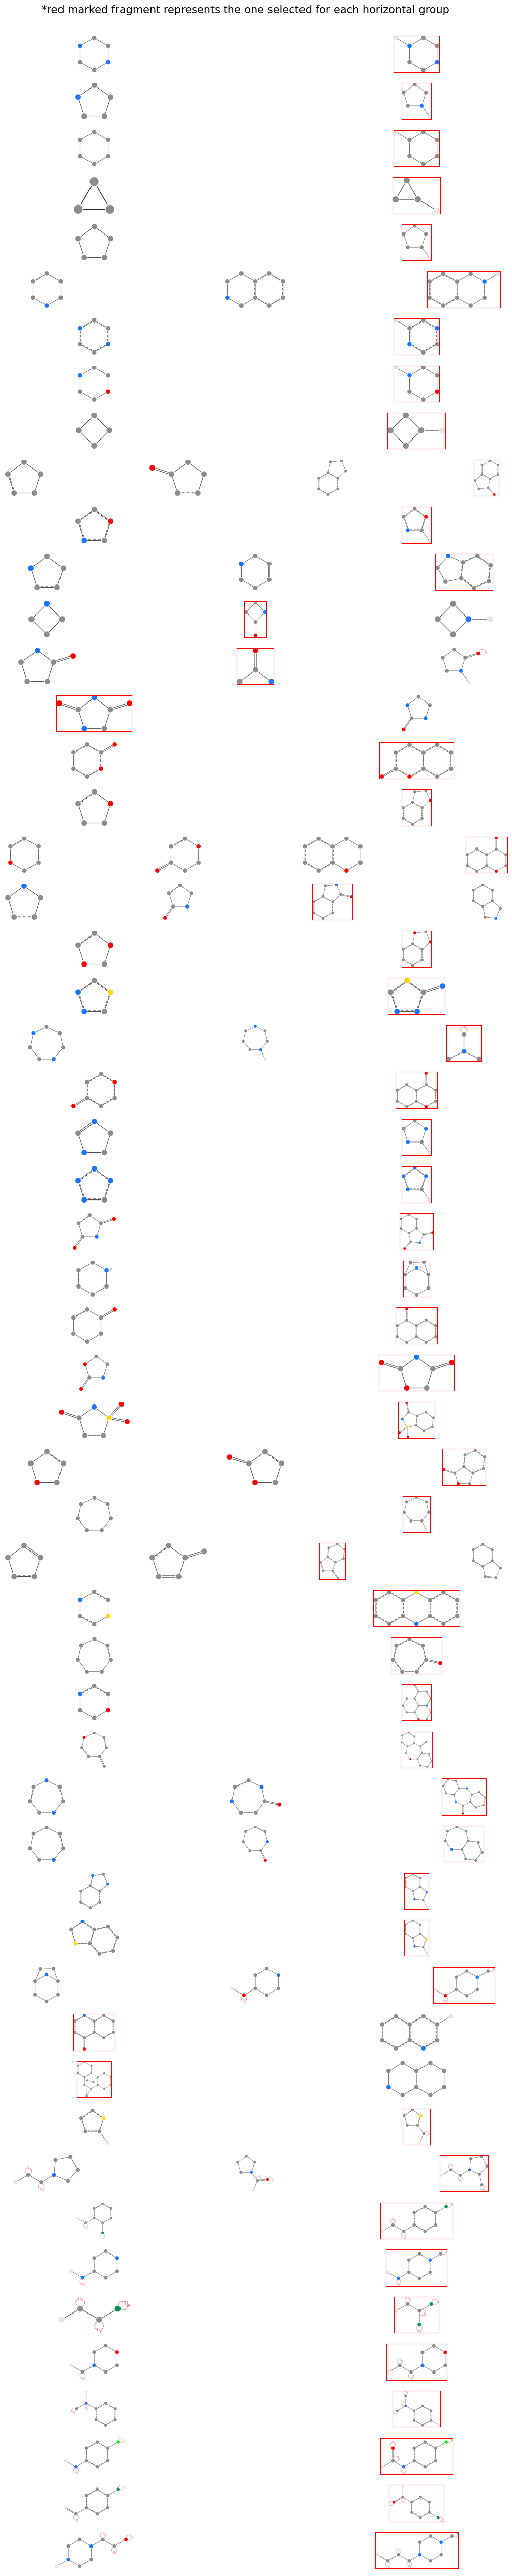

In [42]:
tmpMolGroups = [x for x,y in zip(molGroups, actions) if y is not False]
tmpActions = [y for y in actions if y is not False]
rows = len(tmpMolGroups)
# rows = 3
fig = plt.figure(figsize=(15,50))
subfigs = fig.subfigures(rows,1, wspace=0.03)

for i,(subfig,molGroup, action) in enumerate(zip(subfigs,tmpMolGroups[:rows], tmpActions)):
    axes = subfig.subplots(1, len(molGroup))
    # subfig.suptitle(str(i), x=0, y=.5)
    for j,(ax,molIdx) in enumerate(zip(axes,molGroup)):
        ax.imshow(PIL.Image.open(f"imgSMARTS/{molIdx}.png"),
                    aspect='equal'
                 )
        if j == action:
            for pos in ['top', 'bottom', 'right', 'left']:
                ax.spines[pos].set_edgecolor("red")
        else:
            ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.set_title(str(j))

fig.suptitle("*red marked fragment represents the one selected for each horizontal group", y=1.01, fontsize=15)
# fig.savefig("results/reductedBit.pdf", bbox_inches="tight")

In [ ]:
for _list,idx in zip(molGroups,actions):
    if idx is not False:
        _list.pop(idx)
    else:
        _list.clear()

In [20]:
bitsToDiscard = list(itertools.chain(*molGroups))

In [22]:
trainMatrix=rawMatrix.drop(columns=bitsToDiscard)

In [23]:
trainMatrix

,0,1,2,3,7,8,11,12,14,15,...,981,982,983,984,985,986,988,991,992,993
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
729,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
730,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
731,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
